# Analysing the calibration of the Perch_v2 model on BirdSet

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_data

data, predictions, targets, valid_keys = load_data("../../logs/predictions/perch_v2")

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])


In [3]:
data["PER"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color', 'metrics'])

## Global - all labels incl. non present target labels

In [4]:
from uncertainbird.utils.plotting import print_metrics

# metrics = print_metrics(predictions, targets)

In [5]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

# plot_reliability_diagram(
#     predictions,
#     targets,
#     n_bins=10,
#     title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
# )

## Globael - only classes present in the target labels

```python

In [6]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 411
Number of classes with atleast 5 samples in targets: 372


In [7]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

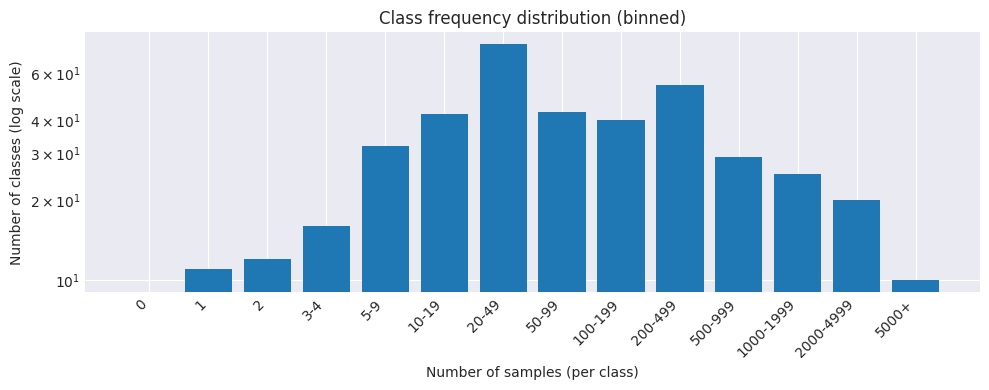

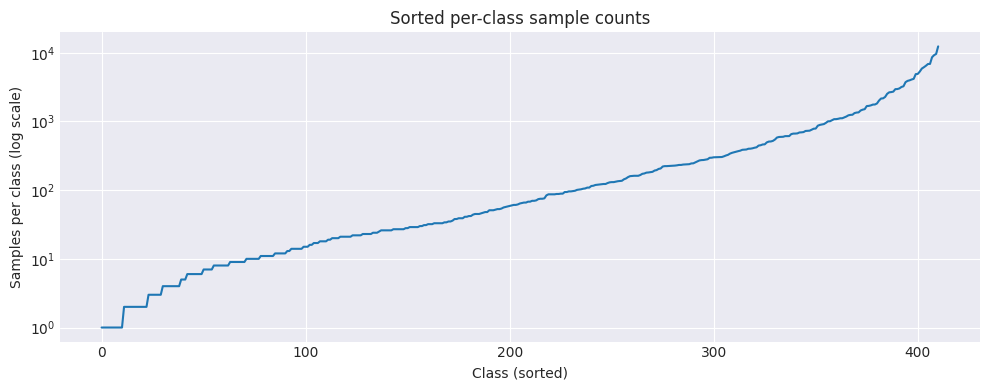

In [8]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [9]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


Accuracy: tensor(0.9985)
cmAP: tensor(0.3916)
Precision: tensor(0.4903)
Recall: tensor(0.0843)
F1 Score: tensor(0.1267)
AUROC: tensor(0.9869)
ECE: tensor(0.0013)
ECE Weighted: tensor(0.0092)
ECE Top-3: tensor(0.0270)
ECE Top-5: tensor(0.0221)
ECE Top-10: tensor(0.0170)
ECE Top-21: tensor(0.0116)
Miscalibration Score (MCS): tensor(-0.0091)
ECE Under-confidence: tensor(0.0091)
ECE Over-confidence: tensor(4.6081e-05)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 0.92%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

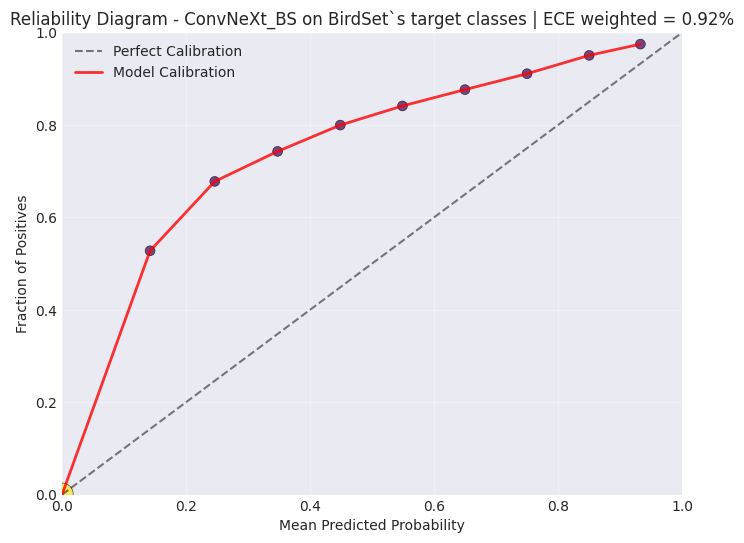

In [10]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [11]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - Perch_v2 on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

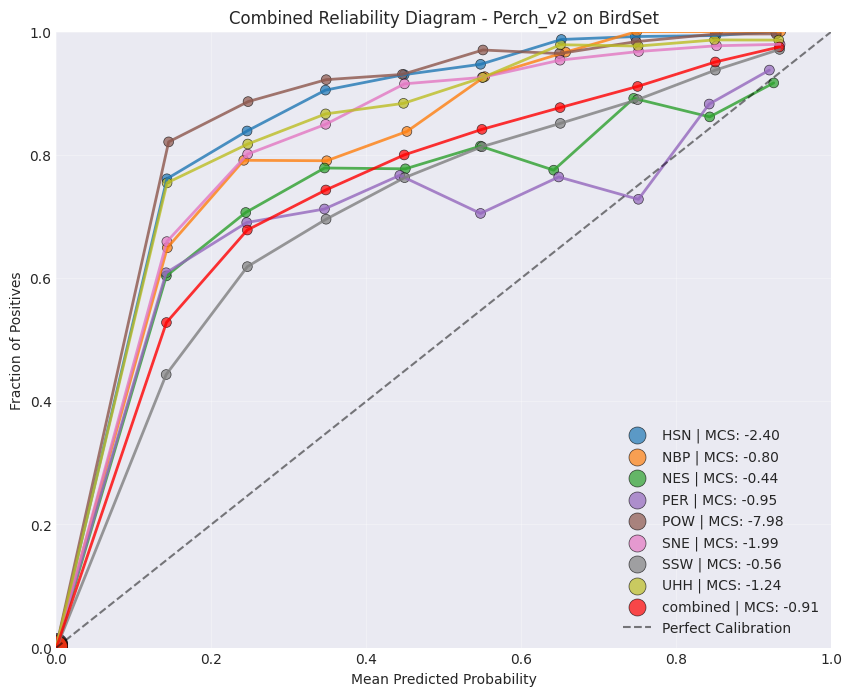

In [18]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - Perch_v2 on BirdSet"
)

#### Per class

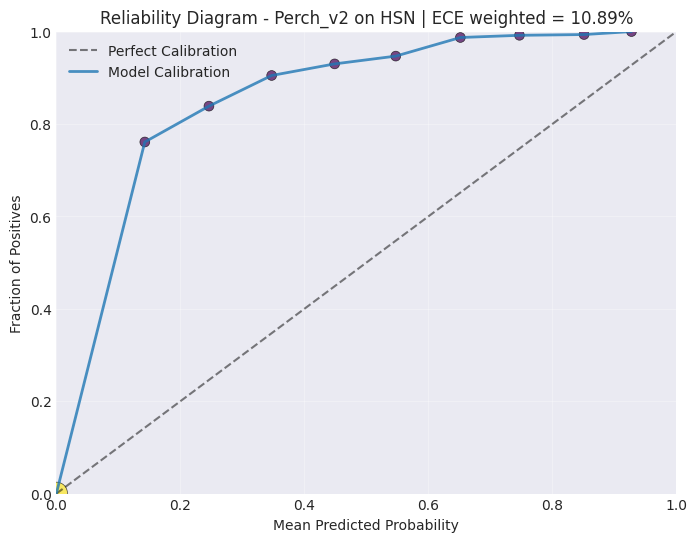

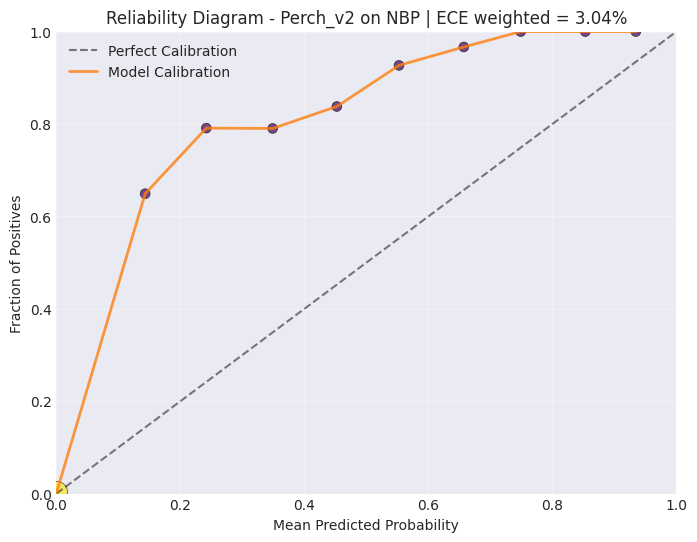

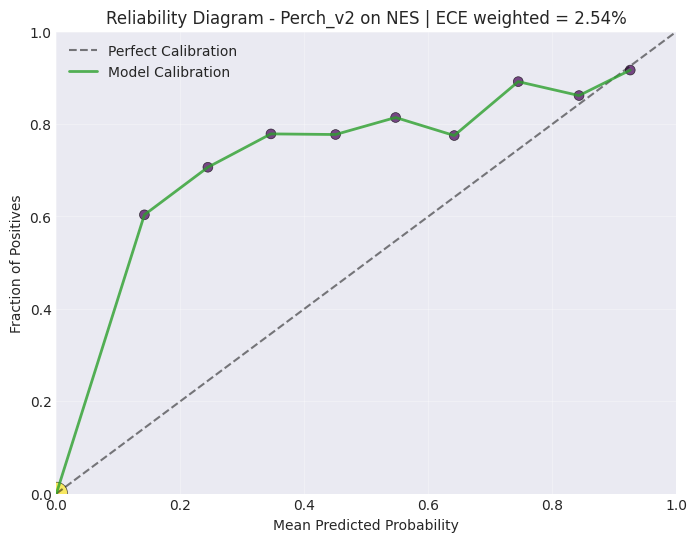

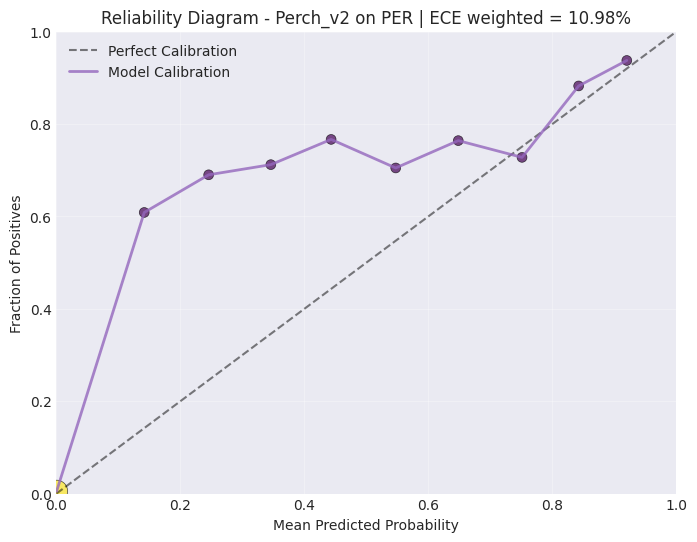

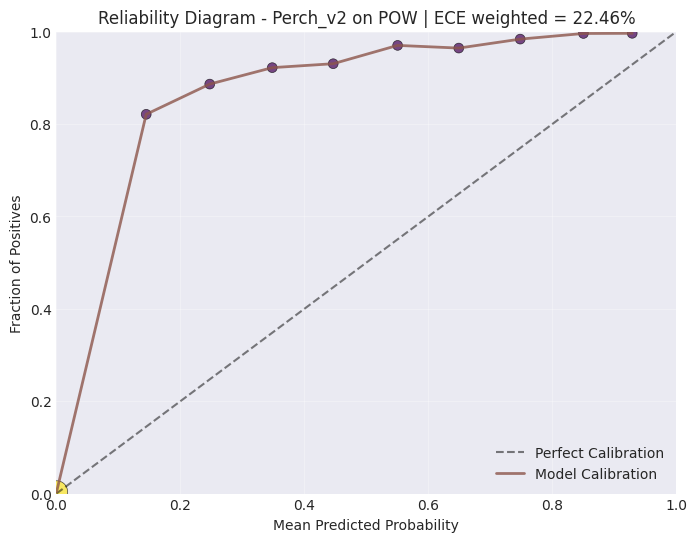

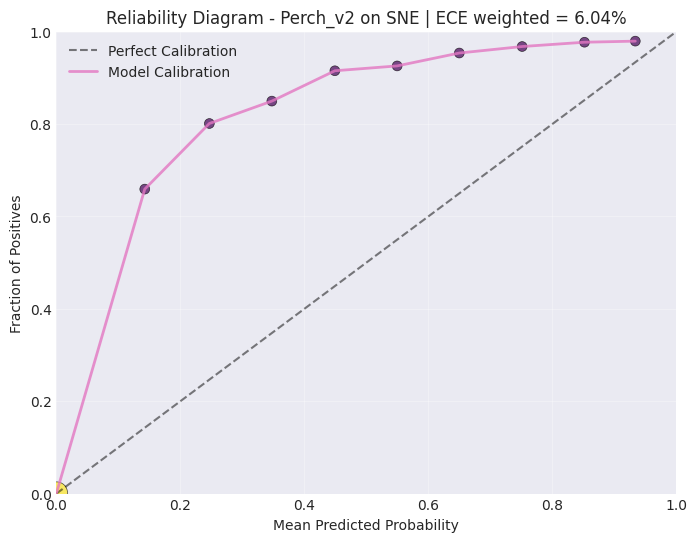

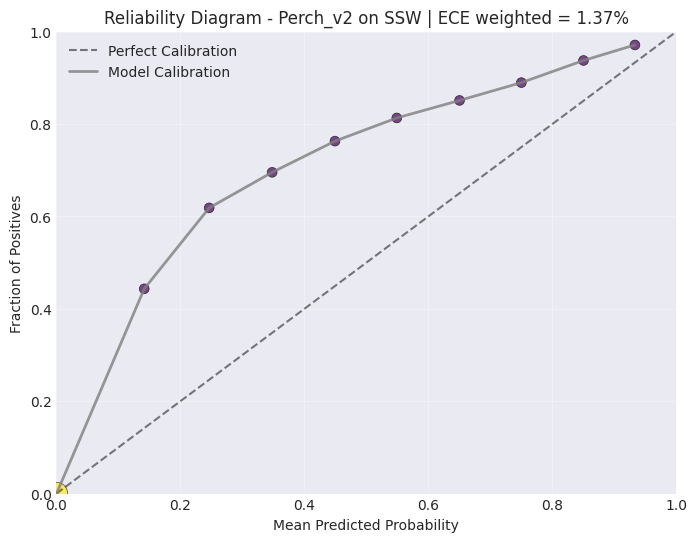

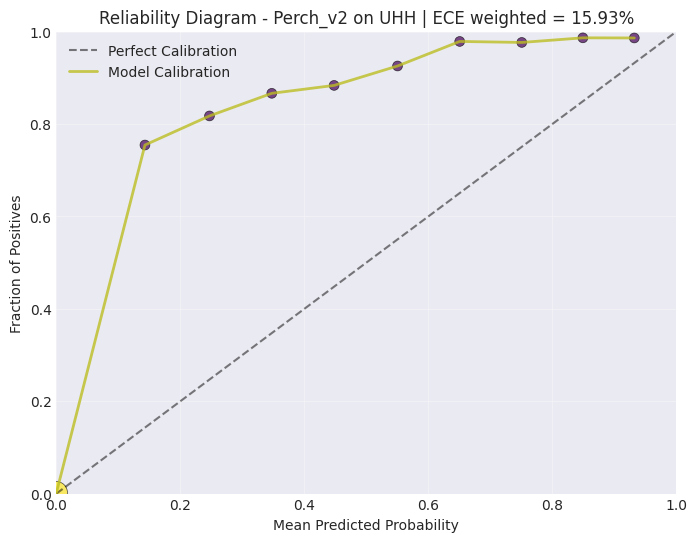

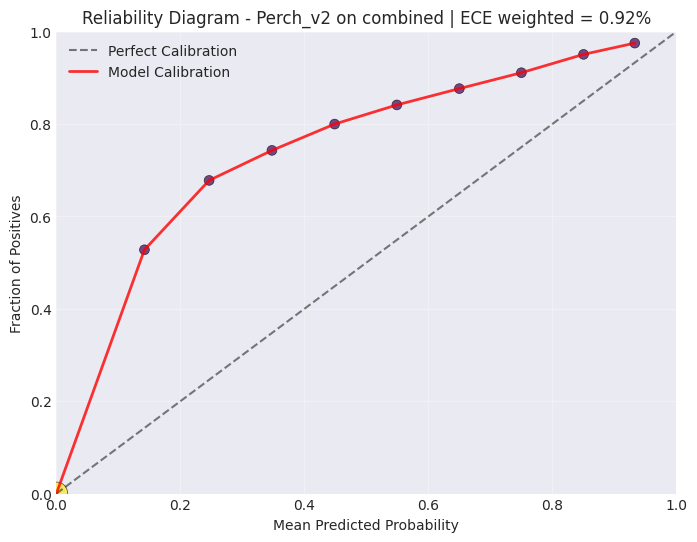

In [19]:
from uncertainbird.utils.plotting import plot_reliability_diagram

for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - Perch_v2 on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [14]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

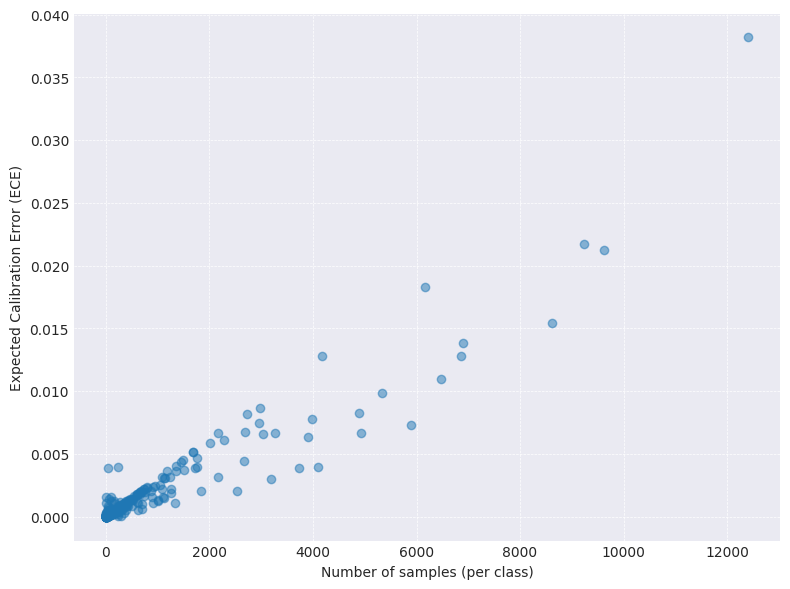

In [15]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)

plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
# plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

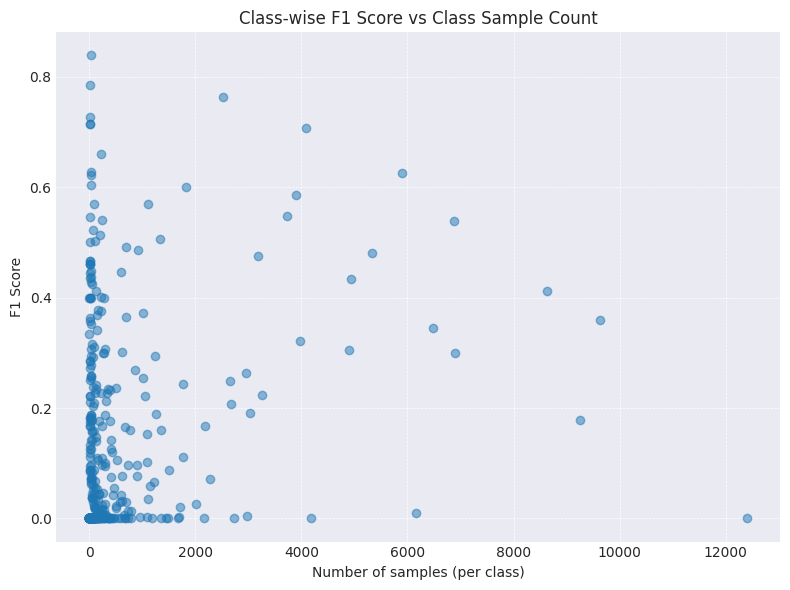

In [16]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [17]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
print("cmAP per dataset:")
for key in data:
    print(f"Dataset: {key}, cmAP: {data[key]['metrics']['cmAP']*100:.2f}")

print("ECE for each dataset:")
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")
print("MCS for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['mcs']*100:.2f}")
print("Under confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_under']*100:.2f}")
print("Over confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_over']*100:.2f}")

cmAP per dataset:
Dataset: HSN, cmAP: 50.75
Dataset: NBP, cmAP: 65.64
Dataset: NES, cmAP: 39.29
Dataset: PER, cmAP: 22.74
Dataset: POW, cmAP: 51.74
Dataset: SNE, cmAP: 33.15
Dataset: SSW, cmAP: 45.25
Dataset: UHH, cmAP: 36.71
Dataset: combined, cmAP: 39.16
ECE for each dataset:
Dataset: HSN, ece: 10.89
Dataset: NBP, ece: 3.04
Dataset: NES, ece: 2.54
Dataset: PER, ece: 10.98
Dataset: POW, ece: 22.46
Dataset: SNE, ece: 6.04
Dataset: SSW, ece: 1.37
Dataset: UHH, ece: 15.93
Dataset: combined, ece: 0.92
MCS for each dataset:
Dataset: HSN, mcs: -2.40
Dataset: NBP, mcs: -0.80
Dataset: NES, mcs: -0.44
Dataset: PER, mcs: -0.95
Dataset: POW, mcs: -7.98
Dataset: SNE, mcs: -1.99
Dataset: SSW, mcs: -0.56
Dataset: UHH, mcs: -1.24
Dataset: combined, mcs: -0.91
Under confidence score for each dataset:
Dataset: HSN, mcs: 2.40
Dataset: NBP, mcs: 0.82
Dataset: NES, mcs: 0.45
Dataset: PER, mcs: 0.97
Dataset: POW, mcs: 7.98
Dataset: SNE, mcs: 1.99
Dataset: SSW, mcs: 0.56
Dataset: UHH, mcs: 1.24
Dataset: co